In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%pip install -q -q keras-tuner
%pip install -q -q shap

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,recall_score,f1_score, ConfusionMatrixDisplay,precision_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import Precision, Recall

## Load in data and verify the contents

In [4]:
# load in data as numpy arrays
X_train = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/X_train.npy")
X_valid = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/X_valid.npy")
X_test = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/X_test.npy")

y_train = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/y_train.npy")
y_valid = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/y_valid.npy")
y_test = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/y_test.npy")

output_label_mapping = np.load("/content/drive/MyDrive/w281 - 2024 Summer - Plant Classification Project/Brian/class_mapping.npy")

In [5]:
# check shapes of the numpy arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12711, 2063)
y_train shape: (12711,)
X_valid shape: (2723, 2063)
y_valid shape: (2723,)
X_test shape: (2725, 2063)
y_test shape: (2725,)


In [6]:
# check output label mapping is as expected
print("Output Label Mapping:")
for idx, item in enumerate(output_label_mapping):
    print(f"{idx}: {item}")

Output Label Mapping:
0: Tomato___Tomato_Yellow_Leaf_Curl_Virus
1: Tomato___Septoria_leaf_spot
2: Tomato___Leaf_Mold
3: Tomato___Early_blight
4: Tomato___Bacterial_spot
5: Tomato___Late_blight
6: Tomato___Spider_mites Two-spotted_spider_mite
7: Tomato___Tomato_mosaic_virus
8: Tomato___healthy
9: Tomato___Target_Spot


## 1. Simple Perceptron Model

Helper Function for displaying evaluation metric

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score
from tensorflow.keras.utils import to_categorical

# Define function helper
def eval_model(model, X_train, y_train, X_valid, y_valid, classes):
    # Generate predictions
    train_preds = np.argmax(model.predict(X_train), axis=1)
    val_preds = np.argmax(model.predict(X_valid), axis=1)

    # Calculate evaluation metrics
    print("\nTrain Accuracy: {:.2f}".format(np.mean(y_train == train_preds)))
    print("Validation Accuracy: {:.2f}".format(np.mean(y_valid == val_preds)))
    print("Validation Recall: {:.2f}".format(recall_score(y_valid, val_preds, average='macro')))
    print("Validation Precision: {:.2f}".format(precision_score(y_valid, val_preds, average='macro', zero_division=0)))
    print("Validation F1 Score: {:.2f}".format(f1_score(y_valid, val_preds, average='macro')))

    # Generate and display confusion matrix
    cm = confusion_matrix(y_valid, val_preds, labels=np.arange(len(classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()


Build and Train Model

In [ ]:
# Initialize the model
simple_perceptron = Sequential([
    Input(shape=(2063,), name='Input'),
    Dense(10, activation='softmax')
])

# Compile the model
simple_perceptron.compile(loss='categorical_crossentropy',
                          optimizer=Adam(learning_rate=0.025),
                          metrics=['accuracy'])

In [ ]:
# # Prepare the data
# y_train_one_hot = to_categorical(y_train, num_classes=10)
y_valid_one_hot = to_categorical(y_valid, num_classes=10)

Evaluate Model on Validation Set

Epoch 1/20
398/398 [==============================] - 2s 4ms/step - loss: 1.9600 - accuracy: 0.3330 - val_loss: 1.9047 - val_accuracy: 0.3625
Epoch 2/20
398/398 [==============================] - 1s 3ms/step - loss: 1.8343 - accuracy: 0.3740 - val_loss: 1.8347 - val_accuracy: 0.3739
Epoch 3/20
398/398 [==============================] - 1s 3ms/step - loss: 1.7802 - accuracy: 0.3842 - val_loss: 1.8044 - val_accuracy: 0.4080
Epoch 4/20
398/398 [==============================] - 1s 3ms/step - loss: 1.7426 - accuracy: 0.3941 - val_loss: 1.7653 - val_accuracy: 0.3996
Epoch 5/20
398/398 [==============================] - 1s 3ms/step - loss: 1.7121 - accuracy: 0.4018 - val_loss: 1.7430 - val_accuracy: 0.4073
Epoch 6/20
398/398 [==============================] - 1s 3ms/step - loss: 1.6872 - accuracy: 0.4114 - val_loss: 1.7144 - val_accuracy: 0.4073
Epoch 7/20
398/398 [==============================] - 1s 3ms/step - loss: 1.6671 - accuracy: 0.4220 - val_loss: 1.6916 - val_accuracy: 0.4091
Epoch 

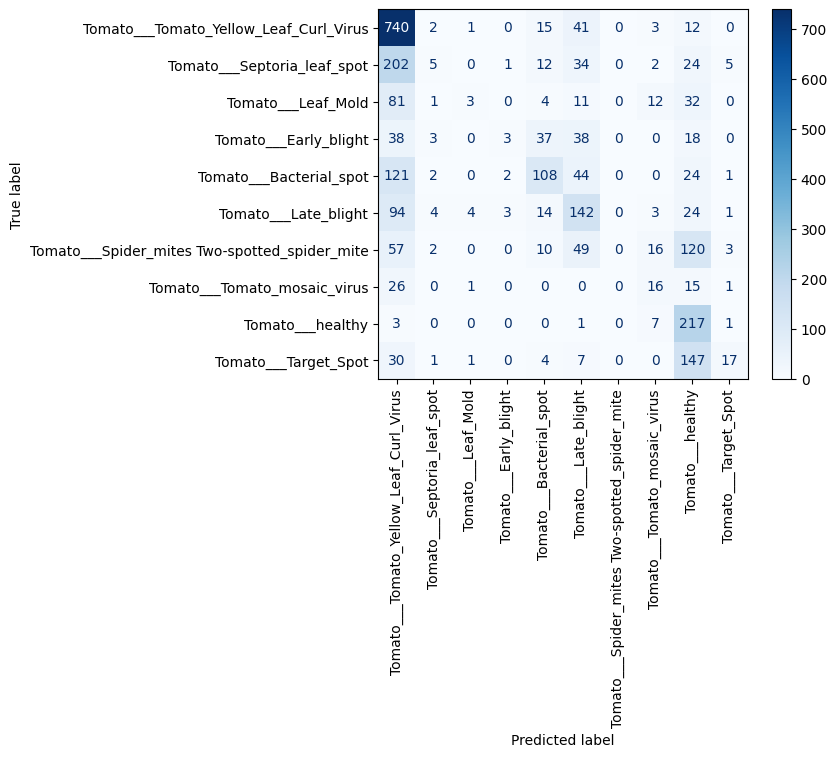

In [ ]:
# Train the model
history = simple_perceptron.fit(X_train, y_train_one_hot, epochs=20, batch_size=32,
                                verbose=1, validation_data=(X_valid, y_valid_one_hot))

# Evaluate the model
eval_model(simple_perceptron, X_train, y_train, X_valid, y_valid, output_label_mapping)

In [ ]:
# Creating a DataFrame from the history dictionary
df = pd.DataFrame(history.history)

# Adding epoch numbers
df['Epoch'] = range(1, len(df) + 1)

# Rearranging columns to have Epoch as the first column
df = df[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Displaying the DataFrame
df


,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,1.959986,0.333019,1.904668,0.362468
1,2,1.834347,0.374007,1.834684,0.373852
2,3,1.780227,0.384155,1.804362,0.408006
3,4,1.742629,0.394147,1.765281,0.399559
4,5,1.712074,0.401778,1.742967,0.407271
5,6,1.687214,0.411376,1.714437,0.407271
6,7,1.667141,0.421997,1.691589,0.409108
7,8,1.644495,0.431359,1.678921,0.428939
8,9,1.628954,0.434270,1.667798,0.426001
9,10,1.615010,0.438518,1.647924,0.416820


### Evaluate Model on Validation Set

In [ ]:
# Metrics for each class

# Load y_train and y_valid
y_train_labels = y_train
y_valid_labels = y_valid

# Decode predictions
train_preds = np.argmax(simple_perceptron.predict(X_train), axis=1)
val_preds = np.argmax(simple_perceptron.predict(X_valid), axis=1)

# Generate classification reports
from sklearn.metrics import classification_report

train_report = classification_report(y_train_labels, train_preds, target_names=output_label_mapping)
val_report = classification_report(y_valid_labels, val_preds, target_names=output_label_mapping)

# Display the reports
print("Training Classification Report:\n", train_report)
print("Validation Classification Report:\n", val_report)


86/86 [==============================] - 0s 4ms/step
Training Classification Report:
                                                precision    recall  f1-score   support

       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.57      0.89      0.70      3724
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00      1245
                           Tomato___Leaf_Mold       0.22      0.11      0.14       670
                        Tomato___Early_blight       0.32      0.02      0.03       721
                      Tomato___Bacterial_spot       0.35      0.66      0.45      1503
                         Tomato___Late_blight       0.50      0.31      0.38      1354
Tomato___Spider_mites Two-spotted_spider_mite       0.26      0.28      0.27      1137
                 Tomato___Tomato_mosaic_virus       0.56      0.06      0.11       258
                             Tomato___healthy       0.50      0.71      0.58      1115
                         Tomato___Target_Sp

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

**The confusion matrix** visualizes the performance of your model. The rows represent the true labels, and the columns represent the predicted labels. For example:

Tomato___Tomato_Yellow_Leaf_Curl_Virus: Most predictions are correct with a high number of true positives (752 true, 33 false negatives, and others misclassified).

Tomato___healthy: This category shows excellent recall with 205 true positives out of a total of 227 actual cases (4 misclassified as something else), indicating that the model very effectively identifies healthy plants.

**Classification Report**
The classification report provides a summary of the precision, recall, F1-score, and support for each class in the dataset:

Precision: Indicates the accuracy of positive predictions. For example:

"Tomato___Tomato_Yellow_Leaf_Curl_Virus", the precision is 0.51, meaning when the model predicts this class, it is correct 51% of the time.
Recall: Indicates the ability to find all positive instances.

"Tomato___Tomato_Yellow_Leaf_Curl_Virus", the recall is 0.92, meaning the model correctly identifies 92% of all actual instances of this disease.

F1-Score: The weighted harmonic mean of precision and recall. A high F1 score means both precision and recall are high. For example, "Tomato___healthy" has an F1 score of 0.54 on the training set and 0.55 on the validation set, indicating good model performance for this class.

Support: The number of actual occurrences of the class in the dataset. For example, "Tomato___Target_Spot" appears 984 times in the training dataset.

**Observations:**

Low Performance in Certain Classes: Some classes like "Tomato___Septoria_leaf_spot" and "Tomato___Early_blight" have very low recall and F1-scores, indicating the model struggles with these diseases.

High Performance in Identifying Healthy Plants: The model is very effective at identifying healthy tomato plants, which might indicate that features associated with healthy plants are well-learned.

Class Imbalance Issues: The lower performance in some classes might also be a result of class imbalance, where some diseases have significantly fewer samples than others, leading to less effective learning by the model.

In [ ]:
# Metrics for model
results = {
    "Train Accuracy": 0.4555896467626465,
    "Validation Accuracy": 0.4476680132207124,
    "Validation Recall": 0.28401584483112097,
    "Validation Precision": 0.24334457941311097,
    "Validation F1 Score": 0.2287652820732718
}

# Display the metrics
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")


Train Accuracy: 0.4556
Validation Accuracy: 0.4477
Validation Recall: 0.2840
Validation Precision: 0.2433
Validation F1 Score: 0.2288


In [ ]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)


Shape of y_train: (12711,)
Shape of y_valid: (2723,)


### Next Steps

1. Compute the ROC Curve and AUC for Each Class.

86/86 [==============================] - 0s 1ms/step


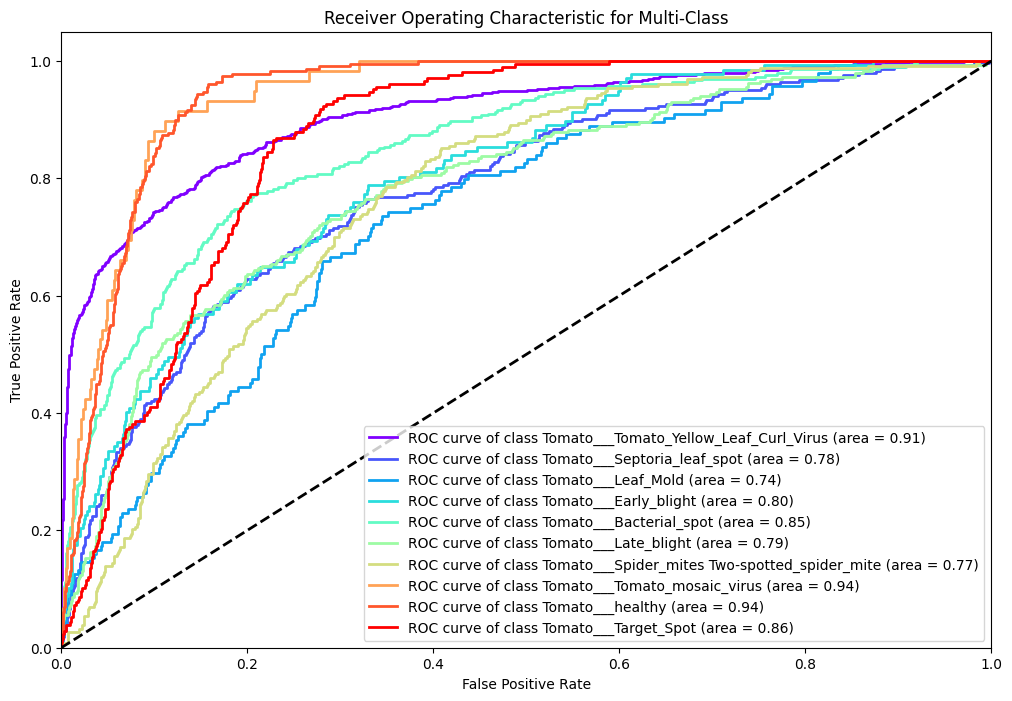

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
val_probs = simple_perceptron.predict(X_valid)

# Function to calculate and plot ROC curve and AUC
def plot_roc_curves(y_true, y_score, n_classes, class_names):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(12, 8))

    colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

# Call the function
plot_roc_curves(to_categorical(y_valid, num_classes=10), val_probs, n_classes=10, class_names=output_label_mapping)


2.   ROC curve for best feature



In [ ]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.5 MB/s eta 0:00:00


In [ ]:
import shap

# Using GradientExplainer as an alternative which might be more flexible
gradient_explainer = shap.GradientExplainer(simple_perceptron, X_train[:100])
gradient_shap_values = gradient_explainer.shap_values(X_valid[:100])
print("Gradient SHAP values shape:", np.array(gradient_shap_values).shape)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Gradient SHAP values shape: (100, 2063, 10)


Colow Augmentation and Edge Detection are preprocessing steps that might not directly result in feature extraction but instead prepare the images for further analysis. The actual features may not be directly derived from these steps unless you are extracting specific statistics or information during these steps.

For Haralick and ResNet50.

**Haralick:** we computed Haralick features per channel, and for each channel, we calculate multiple texture descriptors (contrast, dissimilarity, homogeneity, energy, correlation), so we can name these features based on the channel and the descriptor. For instance:

1. Haralick_R_contrast, Haralick_R_dissimilarity, Haralick_R_homogeneity, Haralick_R_energy, Haralick_R_correlation

2. Haralick_G_contrast, Haralick_G_dissimilarity, Haralick_G_homogeneity, Haralick_G_energy, Haralick_G_correlation

3. Haralick_B_contrast, Haralick_B_dissimilarity, Haralick_B_homogeneity, Haralick_B_energy, Haralick_B_correlation

**ResNet50:** When using a model like ResNet50 to extract features, the feature names are typically less descriptive because they represent higher-level abstractions learned by the network. However, you can name them based on their order in the output vector from the ResNet50 model.

For example: ResNet50_feature_1, ResNet50_feature_2, ..., up to however many features are extracted (typically 2048 for the final average pooling layer of ResNet50).


SHAP values shape (all classes): (100, 2063, 10)
Corrected SHAP values shape for class 0: (100, 2063)


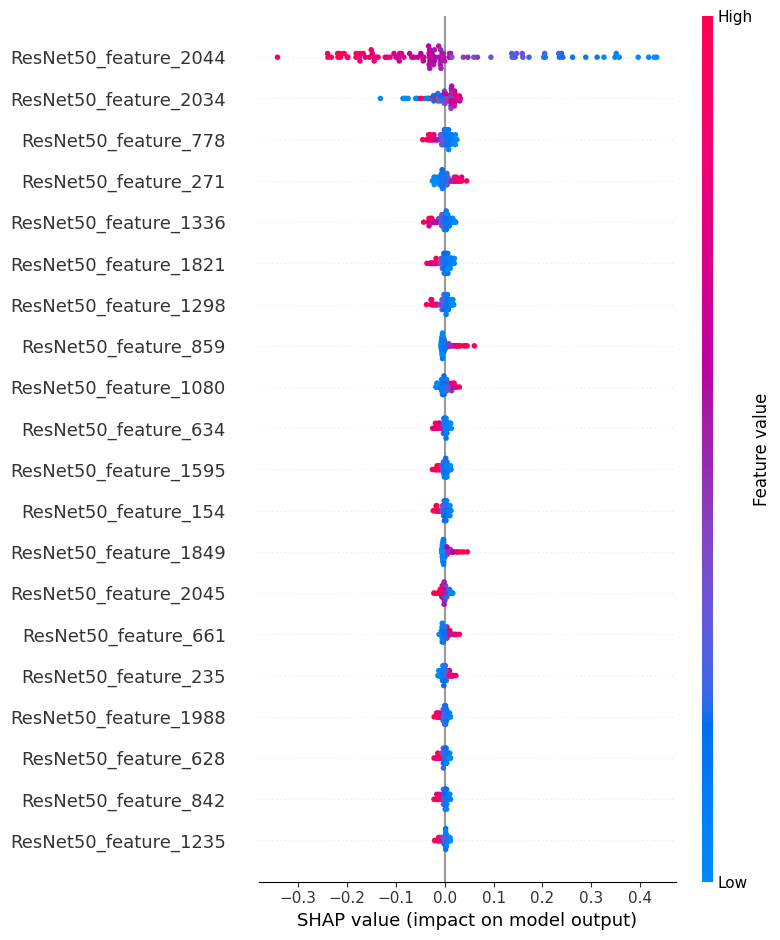

In [ ]:
import shap

# Initialize the GradientExplainer
gradient_explainer = shap.GradientExplainer(simple_perceptron, X_train[:100])

# Compute SHAP values
gradient_shap_values = gradient_explainer.shap_values(X_valid[:100])

# Verify dimensions
print("SHAP values shape (all classes):", np.array(gradient_shap_values).shape)

# Correctly extract SHAP values for class 0, ensuring proper dimensions
shap_values_class_0 = np.array(gradient_shap_values)[:, :, 0]

# Check the new shape of the class 0 SHAP values
print("Corrected SHAP values shape for class 0:", shap_values_class_0.shape)

# Define feature names
# Assuming there are 2048 ResNet50 features and 15 Haralick features per channel (R, G, B)
num_resnet_features = 2048
haralick_descriptors = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
haralick_features = [f"Haralick_{color}_{desc}" for color in ['R', 'G', 'B'] for desc in haralick_descriptors]
resnet_features = [f"ResNet50_feature_{i+1}" for i in range(num_resnet_features)]

# Combine all feature names
feature_names = haralick_features + resnet_features[:X_valid.shape[1] - len(haralick_features)]

# Ensure the number of feature names matches the number of features
if len(feature_names) != X_valid.shape[1]:
    raise ValueError("Mismatch in the number of features and the number of feature names.")

# Summary plot for class 0 SHAP values
shap.summary_plot(shap_values_class_0, X_valid[:100], feature_names=feature_names)


In [ ]:
print("Gradient SHAP values shape:", np.array(gradient_shap_values).shape)  # Should be (100, 2063, 10)
print("Shape of SHAP values for class 0:", shap_values_class_0.shape)  # Should be (100, 2063)
print("Shape of validation features:", X_valid[:100].shape)  # Should be (100, 2063)
print("Number of feature names:", len(feature_names))  # Should be 2063


Gradient SHAP values shape: (100, 2063, 10)
Shape of SHAP values for class 0: (100, 2063)
Shape of validation features: (100, 2063)
Number of feature names: 2063


# 2. Random Forest

Setting up model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on the validation set
val_preds = rf_model.predict(X_valid)

# Generate probabilities for ROC analysis (if needed)
val_probs = rf_model.predict_proba(X_valid)


Evaluate the Model

Validation Classification Report:
                                                precision    recall  f1-score   support

       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.79      0.93      0.85       814
                  Tomato___Septoria_leaf_spot       0.63      0.57      0.60       285
                           Tomato___Leaf_Mold       0.79      0.50      0.61       144
                        Tomato___Early_blight       0.69      0.24      0.36       137
                      Tomato___Bacterial_spot       0.67      0.69      0.68       302
                         Tomato___Late_blight       0.63      0.68      0.65       289
Tomato___Spider_mites Two-spotted_spider_mite       0.61      0.61      0.61       257
                 Tomato___Tomato_mosaic_virus       0.66      0.32      0.43        59
                             Tomato___healthy       0.79      0.85      0.82       229
                         Tomato___Target_Spot       0.59      0.60      0.59       207

      

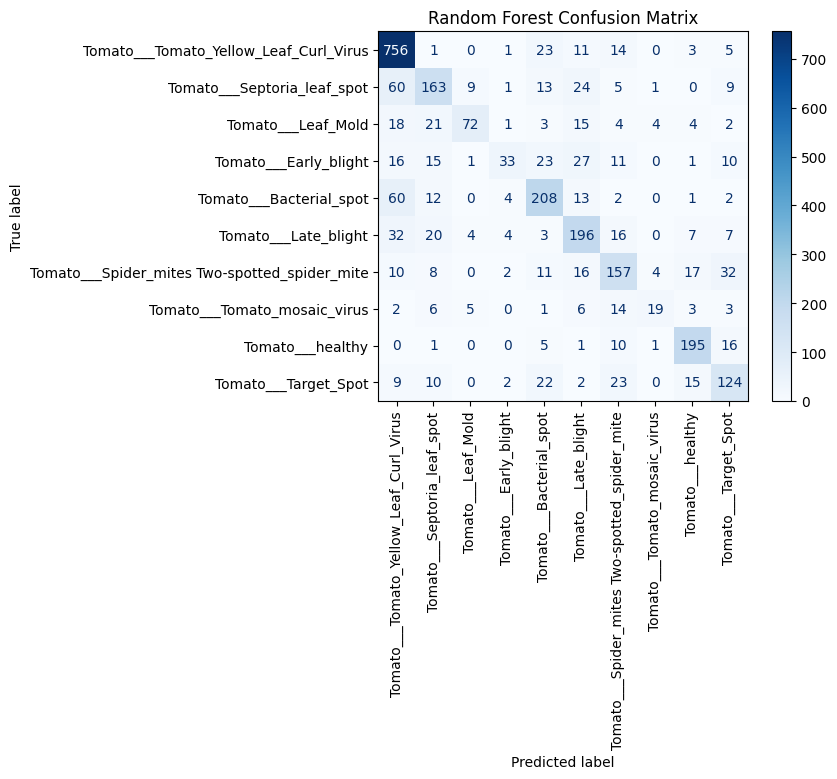

In [ ]:
# Classification report
print("Validation Classification Report:\n", classification_report(y_valid, val_preds, target_names=output_label_mapping))

# Confusion matrix
cm = confusion_matrix(y_valid, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_label_mapping)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(y_valid, val_preds, average='macro')
overall_recall = recall_score(y_valid, val_preds, average='macro')
overall_f1 = f1_score(y_valid, val_preds, average='macro')

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-Score:", overall_f1)


Overall Precision: 0.6846501293468021
Overall Recall: 0.5991986120256841
Overall F1-Score: 0.6212409552877878


ROC Curve for Each Class

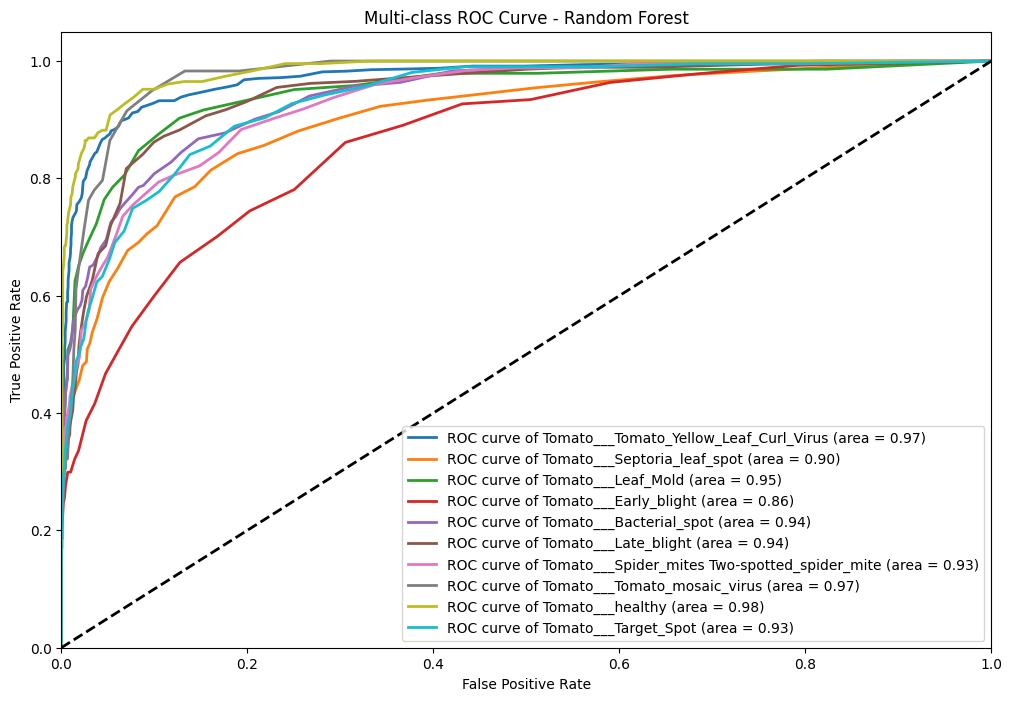

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC analysis
y_valid_binarized = label_binarize(y_valid, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class using RF probabilities
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(output_label_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(output_label_mapping)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of {} (area = {:0.2f})'.format(output_label_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()


SHAP Analysis for RF

Selected a subset because running Shap for the whole dataset was taking long.


100%|===================| 998/1000 [03:47<00:00]       

Flattened feature indices (type): <class 'numpy.ndarray'>
Flattened feature indices (values): [0 1 2 3 4 5 6 7 8 9]
Feature names (length): 2063
Shape of X_sample: (100, 2063)
Shape of shap_values: [(2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10

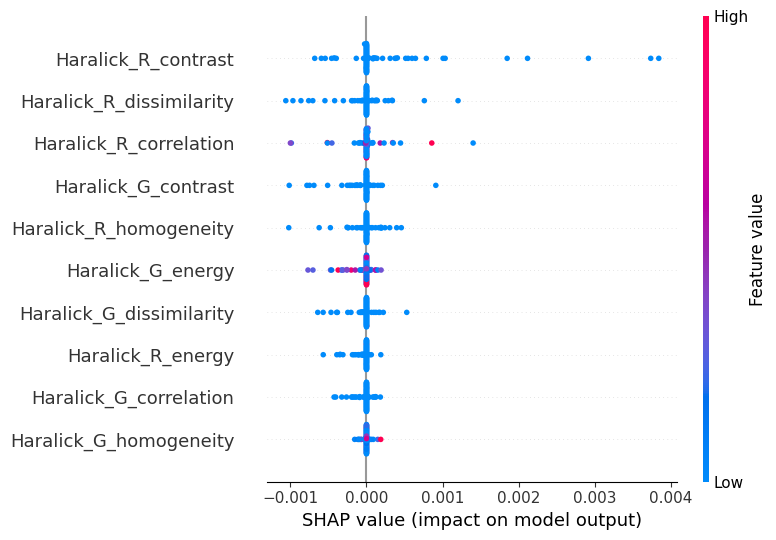

In [ ]:
import shap
import numpy as np

# Sample a subset of the training data for quicker analysis
X_sample = shap.sample(X_train, 100)

# Initialize the SHAP Tree Explainer for Random Forest using the subset
explainer = shap.TreeExplainer(rf_model, X_sample)

# Compute SHAP values for the same subset
shap_values = explainer.shap_values(X_sample)

# Assuming shap_values is a list (one per class), calculate mean absolute SHAP values across all samples and classes
if isinstance(shap_values, list):
    shap_sum = np.sum([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    shap_sum = np.abs(shap_values).mean(axis=0)

# Get the indices of the features sorted by their importance
feature_importance = np.argsort(shap_sum)[::-1]

# Create feature names assuming a combination of Haralick and ResNet50 features
haralick_features = [f"Haralick_{color}_{desc}" for color in ['R', 'G', 'B'] for desc in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]
resnet_features = [f"ResNet50_feature_{i+1}" for i in range(2048)]
feature_names = haralick_features + resnet_features[:X_train.shape[1] - len(haralick_features)]

# For simplicity, consider only the top N features
top_n = 20
selected_feature_indices = feature_importance[:top_n]

# Ensure the indices are integers and valid
selected_feature_indices = selected_feature_indices.astype(int)

# Flatten and ensure unique indices
flattened_indices = np.unique(selected_feature_indices.flatten())

# Debugging output
print("Flattened feature indices (type):", type(flattened_indices))
print("Flattened feature indices (values):", flattened_indices)
print("Feature names (length):", len(feature_names))
print("Shape of X_sample:", X_sample.shape)
print("Shape of shap_values:", [sv.shape for sv in shap_values])

# Check bounds of flattened indices
if np.max(flattened_indices) >= X_sample.shape[1]:
    raise IndexError("Flattened indices are out of bounds for the sample features")

# Generate a summary plot for these top features
selected_features = X_sample[:, flattened_indices]

# Focus on the SHAP values for the first class and correct shape matching
shap_values_class_0 = shap_values[0][:, flattened_indices][:X_sample.shape[0]]

# Verify feature names
try:
    selected_feature_names = [feature_names[i] for i in flattened_indices]
except TypeError as e:
    print(f"Error: {e}")
    print("Feature indices:", flattened_indices)
    print("Feature names available:", len(feature_names))
    raise

# Additional checks before plotting
print("Shape of shap_values_class_0:", shap_values_class_0.shape)
print("Shape of selected_features:", selected_features.shape)
print("Selected feature names:", selected_feature_names)

# Ensure the correct shapes
if shap_values_class_0.shape[0] != selected_features.shape[0]:
    raise ValueError("Mismatch in the number of samples between SHAP values and features")
if shap_values_class_0.shape[1] != len(selected_feature_names):
    raise ValueError("Mismatch in the number of features between SHAP values and selected features")

# Display the SHAP summary plot
shap.summary_plot(shap_values_class_0, selected_features, feature_names=selected_feature_names)

# 3. Logistic Regression

Epoch 1/10
40/40 [==============================] - 2s 22ms/step - loss: 2.2381 - accuracy: 0.2817 - val_loss: 2.1477 - val_accuracy: 0.3076
Epoch 2/10
40/40 [==============================] - 1s 13ms/step - loss: 2.0934 - accuracy: 0.3006 - val_loss: 2.0567 - val_accuracy: 0.3108
Epoch 3/10
40/40 [==============================] - 1s 17ms/step - loss: 2.0260 - accuracy: 0.3155 - val_loss: 2.0189 - val_accuracy: 0.3304
Epoch 4/10
40/40 [==============================] - 1s 14ms/step - loss: 1.9829 - accuracy: 0.3407 - val_loss: 1.9863 - val_accuracy: 0.3470
Epoch 5/10
40/40 [==============================] - 1s 19ms/step - loss: 1.9517 - accuracy: 0.3344 - val_loss: 1.9621 - val_accuracy: 0.3525
Epoch 6/10
40/40 [==============================] - 1s 20ms/step - loss: 1.9293 - accuracy: 0.3493 - val_loss: 1.9420 - val_accuracy: 0.3564
Epoch 7/10
40/40 [==============================] - 1s 19ms/step - loss: 1.9142 - accuracy: 0.3525 - val_loss: 1.9215 - val_accuracy: 0.3478
Epoch 8/10
40

40/40 [==============================] - 0s 5ms/step - loss: 1.4454 - accuracy: 0.4941
Test Loss: 1.4453880786895752, Test Accuracy: 0.49409914016723633
40/40 [==============================] - 0s 6ms/step


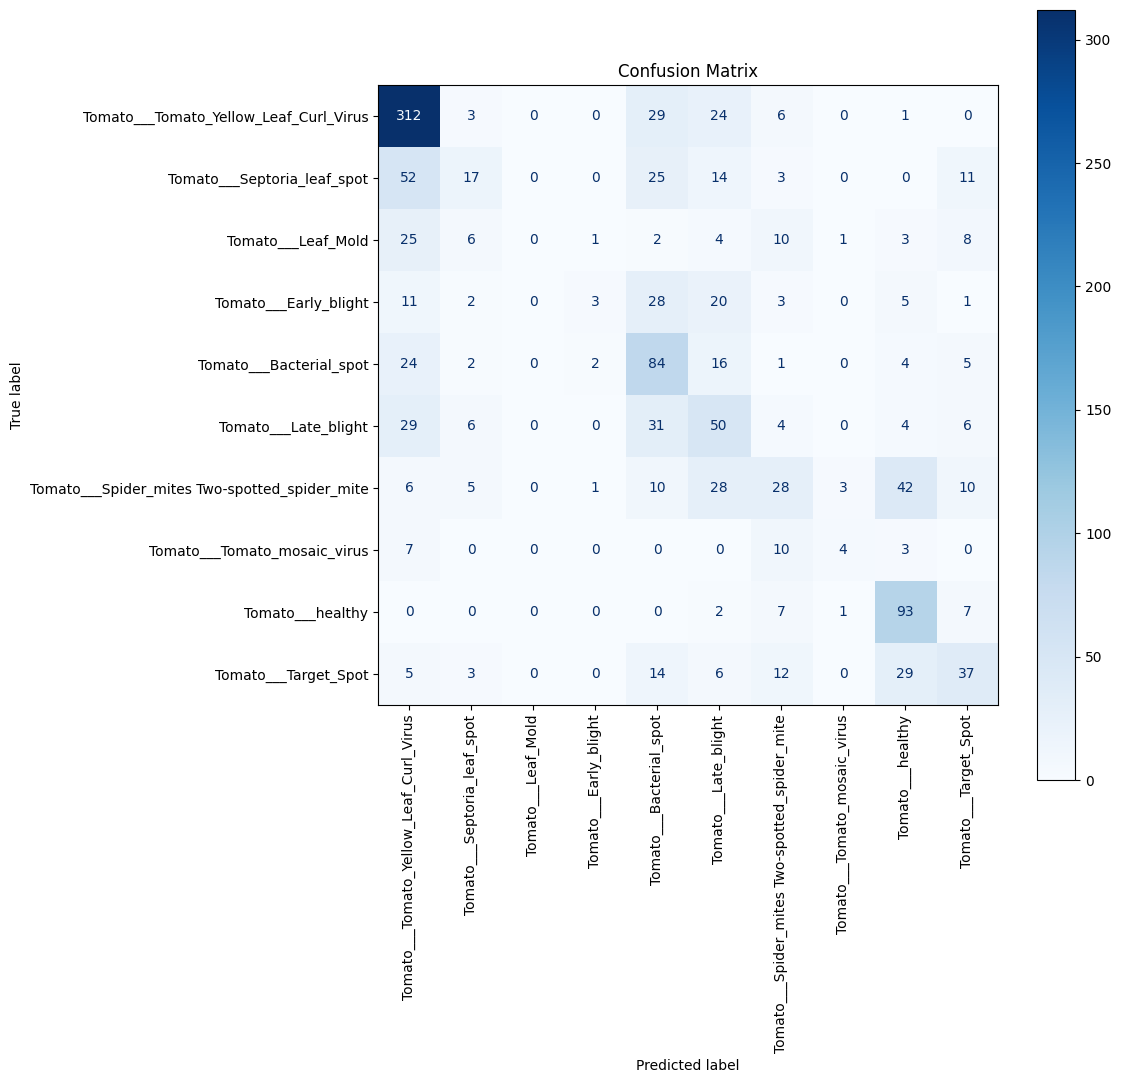

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Accuracy: 0.4940991345397325
Precision: 0.45254518718604014
Recall: 0.4940991345397325
F1 Score: 0.44555362095701934
                                               precision    recall  f1-score   support

       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.66      0.83      0.74       375
                  Tomato___Septoria_leaf_spot       0.39      0.14      0.20       122
                           Tomato___Leaf_Mold       0.00      0.00      0.00        60
                        Tomato___Early_blight       0.43      0.04      0.07        73
                      Tomato___Bacterial_spot       0.38      0.61      0.47       138
                         Tomato___Late_blight       0.30      0.38      0.34       130
Tomato___Spider_mites Two-spotted_spider_mite       0.33      0.21      0.26       133
                 Tomato___Tomato_mosaic_virus       0.44      0.17      0.24        24
                             Tomato___healthy       0.51      0.85      0.63       110
            

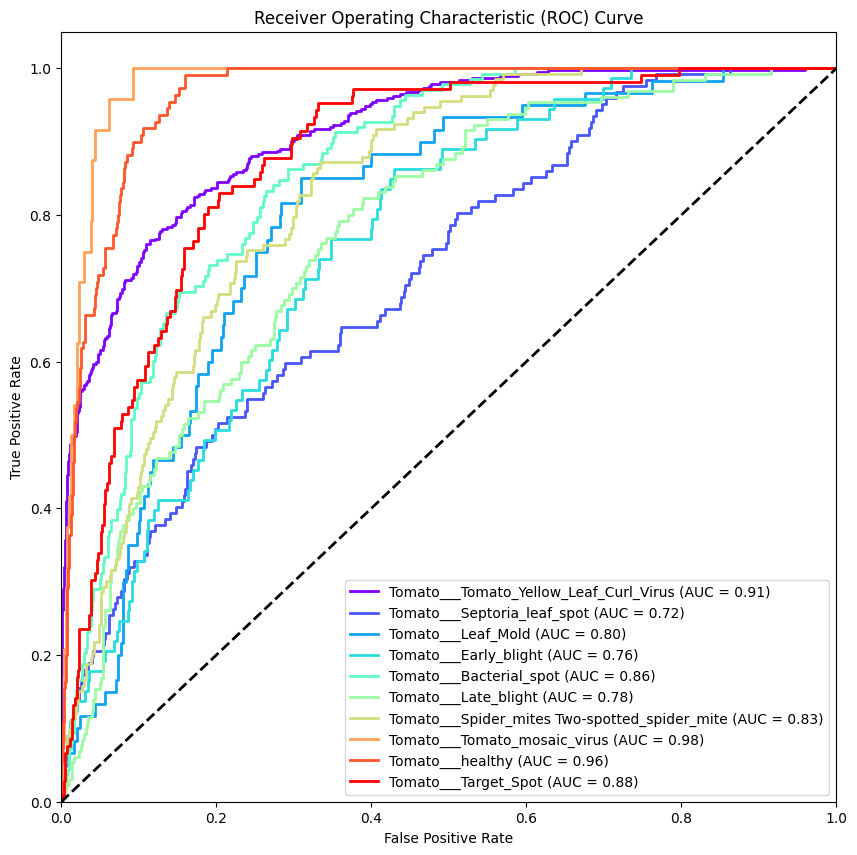

In [ ]:
# import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Sample data function
def sample_data(X, y, sample_size, stratify=None):
    if stratify is None:
        indices = np.random.choice(np.arange(len(X)), size=sample_size, replace=False)
    else:
        from sklearn.model_selection import train_test_split
        _, X_sample, _, y_sample = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
        return X_sample, y_sample
    return X[indices], y[indices]

# Sampling 10% of the data
sample_size = int(0.1 * len(X_train))
X_train_sample, y_train_sample = sample_data(X_train, y_train, sample_size)
X_valid_sample, y_valid_sample = sample_data(X_valid, y_valid, sample_size)
X_test_sample, y_test_sample = sample_data(X_test, y_test, sample_size)

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_sample, num_classes=np.unique(y_train).size)
y_valid_one_hot = to_categorical(y_valid_sample, num_classes=np.unique(y_train).size)

# Define the model architecture for multi-class classification
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_sample.shape[1]),
    Dense(64, activation='relu'),
    Dense(np.unique(y_train).size, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train_sample, y_train_one_hot, validation_data=(X_valid_sample, y_valid_one_hot), epochs=10, batch_size=32)

# Hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_dim=X_train_sample.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(np.unique(y_train).size, activation='softmax'))

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of variations on hyperparameters
    executions_per_trial=1,  # Number of models that should be built and fit for each trial
    directory='model_tuning',
    project_name='KerasTunerDemo'
)

tuner.search(X_train_sample, y_train_one_hot, validation_data=(X_valid_sample, y_valid_one_hot), epochs=20, batch_size=32)

# Get the best model after tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_sample, to_categorical(y_test_sample, num_classes=np.unique(y_train).size))
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Confusion matrix
# Predict class probabilities
y_pred_prob = best_model.predict(X_test_sample)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_test_sample

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Correct label mapping based on the provided file
label_mapping = [
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Leaf_Mold",
    "Tomato___Early_blight",
    "Tomato___Bacterial_spot",
    "Tomato___Late_blight",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy",
    "Tomato___Target_Spot"
]

class_names = [label_mapping[idx] for idx in range(len(label_mapping))]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix")
plt.show()

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ROC model

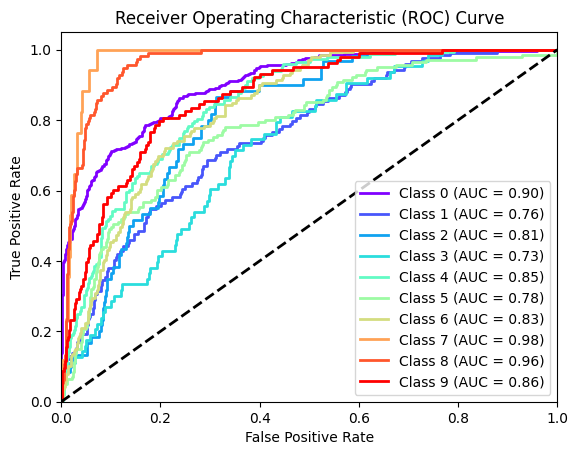

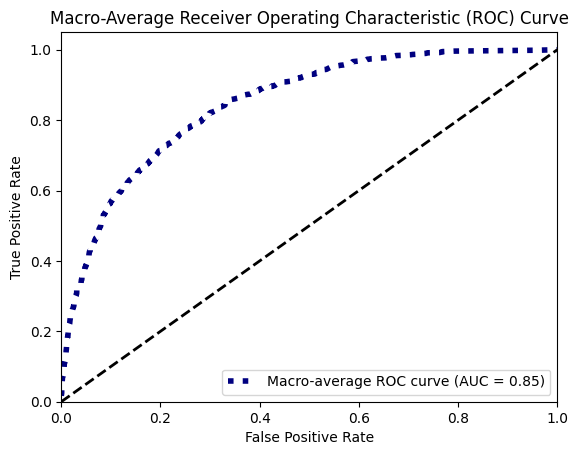

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have your true labels and predicted probabilities
# y_true = y_test_sample (already defined)
# y_pred_prob = best_model.predict(X_test_sample) (already defined)

# Binarize the output labels
y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

# Number of classes
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Macro-average ROC curve and AUC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this point
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle=':', linewidth=4,
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Hyperparameter tuning of Random Forest

Here we do some hyperparameter tuning on our best model, the random forest.

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Define the parameters of the grid search
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform a grid search
grid_search = HalvingGridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    resource='n_estimators',
    factor=4,
    max_resources=256,
    cv=5,
    scoring='f1_macro',
    refit=True,
    verbose=2,
)
grid_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 16
max_resources_: 256
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 18
n_resources: 16
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=16; total time=   3.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=16; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=16; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=16; total time=   3.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=16; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=16; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=16; total time=   2.3s
[CV] END max_depth=None, min

HalvingGridSearchCV(estimator=RandomForestClassifier(n_jobs=-1,
                                                     random_state=42),
                    factor=4, max_resources=256,
                    param_grid={'max_depth': [None, 10, 20],
                                'min_samples_leaf': [1, 2],
                                'min_samples_split': [2, 5, 8]},
                    resource='n_estimators', scoring='f1_macro', verbose=2)

In [48]:
# Utility function to report best scores
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.524 (std: 0.007)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 256}

Model with rank: 2
Mean validation score: 0.524 (std: 0.009)
Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 256}

Model with rank: 3
Mean validation score: 0.513 (std: 0.006)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 64}



In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize and train the Random Forest model with the optimal parameters
best_model = np.flatnonzero(grid_search.cv_results_["rank_test_score"] == 1)[0]
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **grid_search.cv_results_["params"][best_model])
rf_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=256, n_jobs=-1,
                       random_state=42)

Validation Set Classification Report:
                                                precision    recall  f1-score   support

       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.79      0.93      0.86       814
                  Tomato___Septoria_leaf_spot       0.62      0.55      0.59       285
                           Tomato___Leaf_Mold       0.76      0.47      0.58       144
                        Tomato___Early_blight       0.85      0.24      0.38       137
                      Tomato___Bacterial_spot       0.65      0.68      0.66       302
                         Tomato___Late_blight       0.63      0.69      0.66       289
Tomato___Spider_mites Two-spotted_spider_mite       0.63      0.60      0.62       257
                 Tomato___Tomato_mosaic_virus       0.61      0.39      0.47        59
                             Tomato___healthy       0.76      0.85      0.80       229
                         Tomato___Target_Spot       0.58      0.60      0.59       207

  

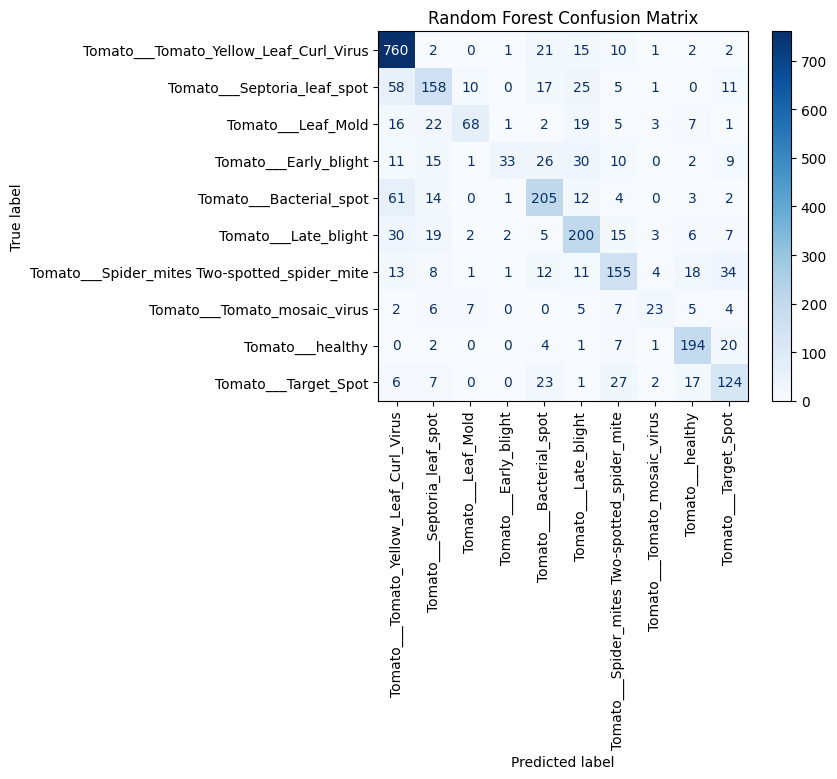

In [51]:
# Predict on the validation set
val_preds = rf_model.predict(X_valid)

# Generate probabilities for ROC analysis (if needed)
val_probs = rf_model.predict_proba(X_valid)

# Classification report
print("Validation Set Classification Report:\n", classification_report(y_valid, val_preds, target_names=output_label_mapping))

# Confusion matrix
cm = confusion_matrix(y_valid, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_label_mapping)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Random Forest Confusion Matrix')
plt.show()

Test Set Classification Report:
                                                precision    recall  f1-score   support

       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.75      0.91      0.82       806
                  Tomato___Septoria_leaf_spot       0.49      0.41      0.44       267
                           Tomato___Leaf_Mold       0.75      0.31      0.44       132
                        Tomato___Early_blight       0.68      0.15      0.24       128
                      Tomato___Bacterial_spot       0.61      0.63      0.62       313
                         Tomato___Late_blight       0.58      0.62      0.60       287
Tomato___Spider_mites Two-spotted_spider_mite       0.59      0.56      0.58       284
                 Tomato___Tomato_mosaic_virus       0.65      0.44      0.52        50
                             Tomato___healthy       0.70      0.79      0.74       231
                         Tomato___Target_Spot       0.50      0.52      0.51       227

        

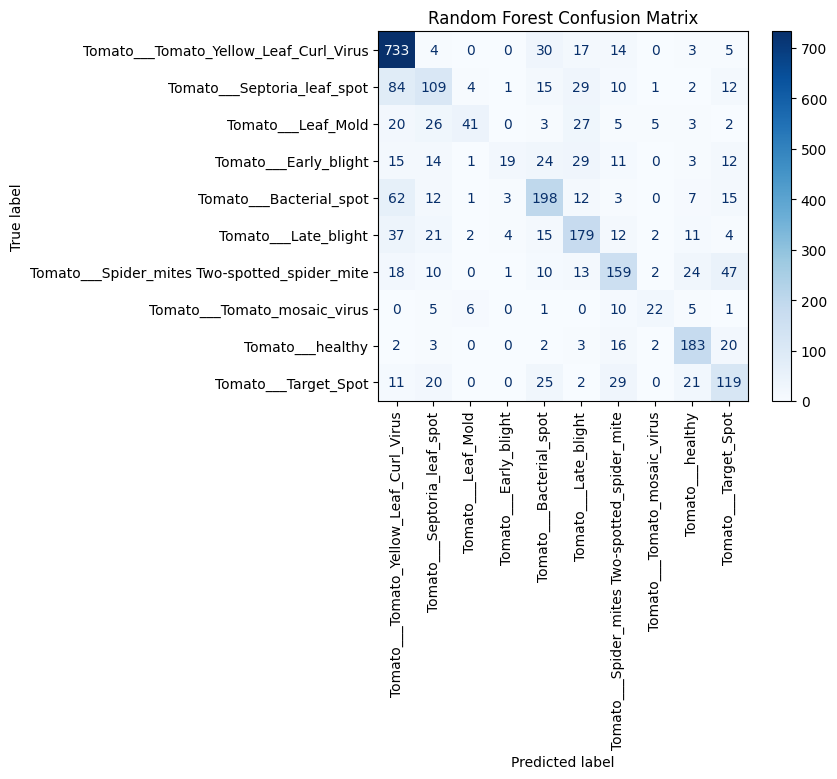

In [52]:
# Predict on the test set
val_preds_test = rf_model.predict(X_test)

# Generate probabilities for ROC analysis (if needed)
val_probs_test = rf_model.predict_proba(X_test)

# Classification report
print("Test Set Classification Report:\n", classification_report(y_test, val_preds_test, target_names=output_label_mapping))

# Confusion matrix
cm = confusion_matrix(y_test, val_preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_label_mapping)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Random Forest Confusion Matrix')
plt.show()

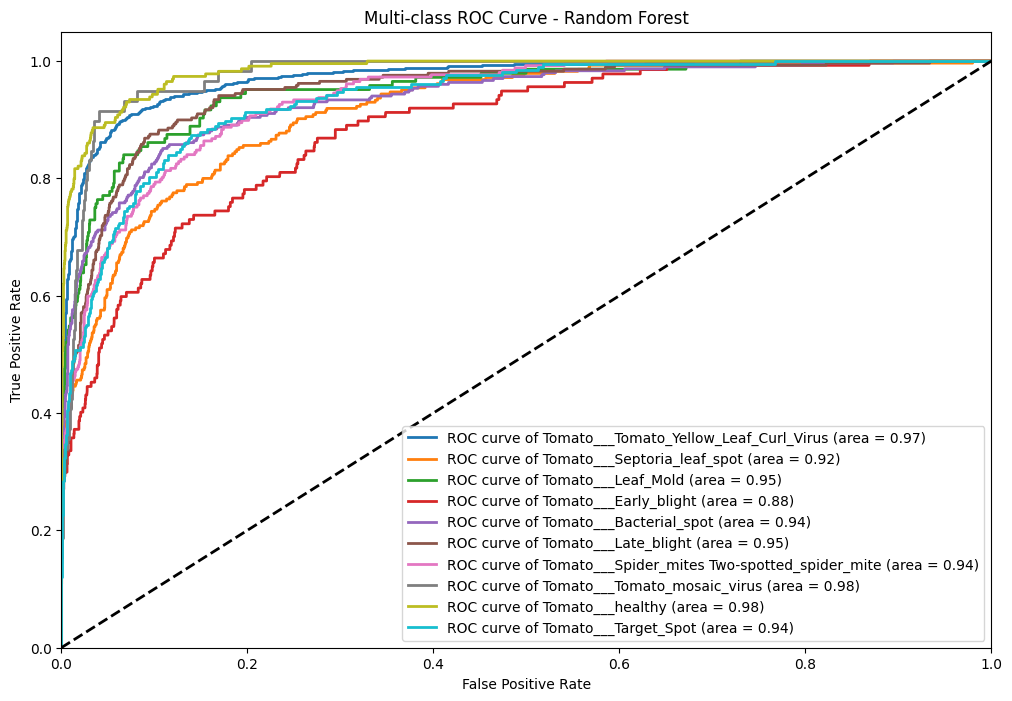

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC analysis
y_valid_binarized = label_binarize(y_valid, classes=np.unique(y_train))

# Compute ROC curve and ROC area for each class using RF probabilities
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(output_label_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(output_label_mapping)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of {} (area = {:0.2f})'.format(output_label_mapping[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

100%|===================| 998/1000 [07:01<00:00]       

Flattened feature indices (type): <class 'numpy.ndarray'>
Flattened feature indices (values): [0 1 2 3 4 5 6 7 8 9]
Feature names (length): 2063
Shape of X_sample: (100, 2063)
Shape of shap_values: [(2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10), (2063, 10

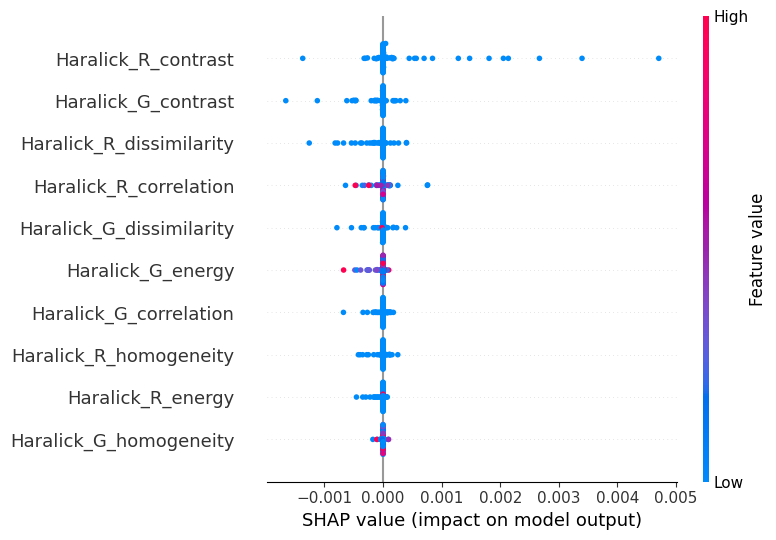

In [54]:
import shap
import numpy as np

# Sample a subset of the training data for quicker analysis
X_sample = shap.sample(X_train, 100)

# Initialize the SHAP Tree Explainer for Random Forest using the subset
explainer = shap.TreeExplainer(rf_model, X_sample)

# Compute SHAP values for the same subset
shap_values = explainer.shap_values(X_sample)

# Assuming shap_values is a list (one per class), calculate mean absolute SHAP values across all samples and classes
if isinstance(shap_values, list):
    shap_sum = np.sum([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    shap_sum = np.abs(shap_values).mean(axis=0)

# Get the indices of the features sorted by their importance
feature_importance = np.argsort(shap_sum)[::-1]

# Create feature names assuming a combination of Haralick and ResNet50 features
haralick_features = [f"Haralick_{color}_{desc}" for color in ['R', 'G', 'B'] for desc in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]
resnet_features = [f"ResNet50_feature_{i+1}" for i in range(2048)]
feature_names = haralick_features + resnet_features[:X_train.shape[1] - len(haralick_features)]

# For simplicity, consider only the top N features
top_n = 20
selected_feature_indices = feature_importance[:top_n]

# Ensure the indices are integers and valid
selected_feature_indices = selected_feature_indices.astype(int)

# Flatten and ensure unique indices
flattened_indices = np.unique(selected_feature_indices.flatten())

# Debugging output
print("Flattened feature indices (type):", type(flattened_indices))
print("Flattened feature indices (values):", flattened_indices)
print("Feature names (length):", len(feature_names))
print("Shape of X_sample:", X_sample.shape)
print("Shape of shap_values:", [sv.shape for sv in shap_values])

# Check bounds of flattened indices
if np.max(flattened_indices) >= X_sample.shape[1]:
    raise IndexError("Flattened indices are out of bounds for the sample features")

# Generate a summary plot for these top features
selected_features = X_sample[:, flattened_indices]

# Focus on the SHAP values for the first class and correct shape matching
shap_values_class_0 = shap_values[0][:, flattened_indices][:X_sample.shape[0]]

# Verify feature names
try:
    selected_feature_names = [feature_names[i] for i in flattened_indices]
except TypeError as e:
    print(f"Error: {e}")
    print("Feature indices:", flattened_indices)
    print("Feature names available:", len(feature_names))
    raise

# Additional checks before plotting
print("Shape of shap_values_class_0:", shap_values_class_0.shape)
print("Shape of selected_features:", selected_features.shape)
print("Selected feature names:", selected_feature_names)

# Ensure the correct shapes
if shap_values_class_0.shape[0] != selected_features.shape[0]:
    raise ValueError("Mismatch in the number of samples between SHAP values and features")
if shap_values_class_0.shape[1] != len(selected_feature_names):
    raise ValueError("Mismatch in the number of features between SHAP values and selected features")

# Display the SHAP summary plot
shap.summary_plot(shap_values_class_0, selected_features, feature_names=selected_feature_names)